<a href="https://colab.research.google.com/github/matpaolacci/masked-lm-for-audio/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurations

## Set the paths

In [1]:
import os, sys

# Paths
DATASET_HOME_DIR = '/content/drive/MyDrive/DLProj/Dataset'
RAW_DATASET_DIR = os.path.join(DATASET_HOME_DIR, "OriginalVersion")        # the Slackh2100 dataset
WAV_DATASET_DIR = os.path.join(DATASET_HOME_DIR, "WavVersion")             # the Slackh2100 dataset with .wav stems
UTILITIES_DIR = '/content/drive/MyDrive/DLProj/Utilities'
CHECKPOINTS_DIR = '/content/drive/MyDrive/DLProj/Checkpoints'

sys.path.append(UTILITIES_DIR)

## Set Configuration variables

In [2]:
# Set this to True if you want create the dataset
PREPARE_DATASET = False
USE_STEMS = False # if true we use stems to train vqvae else use mixes tracks

### Use pre-trained model
If you want continue the training from previously saved model compile the following section by declaring the path to the model along with the path of used hyperparametes

In [3]:
USE_PRE_SAVED_MODEL = False

# Set following fields only if previous variable has been set to True
model_checkpoints_dir = os.path.join(CHECKPOINTS_DIR, '2024-09-14_123325')
PATH_TO_PRE_SAVED_MODEL = os.path.join(model_checkpoints_dir, 'VQVAE_19999_EPOCH')

PATH_TO_HYPERPARAMETERS = os.path.join(model_checkpoints_dir, 'hyper_params.json')

# Set for how many epochs the presaved model will be trained
EPOCHS_RE_TRAIN = 3000

### Use pre-trained model for evaluation

In [4]:
ONLY_EVALUATION = False
EVAL_CHECKPOINT_DIR = os.path.join(CHECKPOINTS_DIR, "2024-09-14_180502")
PATH_TO_MODEL_TO_EVALUATE = os.path.join(EVAL_CHECKPOINT_DIR, "VQVAE_19979_EPOCH")
PATH_TO_HYPERPARAMETERS_EVALUATION = os.path.join(EVAL_CHECKPOINT_DIR, 'hyper_params.json')

## Install the required python packages

In [5]:
!pip install -r $UTILITIES_DIR/requirements.txt

## Import libraries

In [6]:
import zipfile, yaml
import flacconverter as fc
from enum import Enum
from tqdm import tqdm
from datetime import datetime, timedelta
import gc
import json

import torch, torchaudio, pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# For getting data structure from list
import ast

# Libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# To plot the graphs of loss and perplexity
from scipy.signal import savgol_filter

## Create checkpoints directory
It will be created a directory for each training, each one will contain the best trained model across the epochs and a file containing the used hyper parameters.

In [7]:
datetime_start = (datetime.now() + timedelta(hours=2)).strftime("%Y-%m-%d_%H%M%S")
CURR_CHECKPOINT_DIR = os.path.join(CHECKPOINTS_DIR, datetime_start)
if not ONLY_EVALUATION:
    os.makedirs(CURR_CHECKPOINT_DIR, exist_ok=True)

## Set log file and log function

In [8]:
data = datetime.now().strftime("%Y-%m-%d")
LOG_FILE_PATH = os.path.join(CURR_CHECKPOINT_DIR, f'{data}.log')

def log(message: str):
    if ONLY_EVALUATION:
        return

    with open(LOG_FILE_PATH, "a") as log_file:
        now = datetime.now()
        now_local = now + timedelta(hours=2)
        log_file.write(f'[{now_local.strftime("%Y-%m-%d %H:%M:%S")}] - {message}\n')

# Prepare the data
In this section we are going to download the Slakh2100 dataset available [here](http://www.slakh.com/)

In [9]:
class Instrument(Enum):
    BASS = 'Bass'
    BRASS = 'Brass'
    CHROMATIC_PERCUSSION = 'Chromatic Percussion'
    DRUMS = 'Drums'
    ETHNIC = 'Ethnic'
    GUITAR = 'Guitar'
    ORGAN = 'Organ'
    PERCUSSIVE = 'Percussive'
    PIANO = 'Piano'
    PIPE = 'Pipe'
    REED = 'Reed'
    SOUND_EFFECTS = 'Sound Effects'
    STRINGS = 'Strings'
    STRINGS_CONTINUED = 'Strings (continued)'
    SYNTH_LEAD = 'Synth Lead'
    SYNTH_PAD = 'Synth Pad'

def extractZipDataset():
    # Apri il file ZIP e estrai i contenuti
    with zipfile.ZipFile(os.path.join(RAW_DATASET_DIR, 'dataset.zip'), 'r') as zipRef:
        zipRef.extractall(RAW_DATASET_DIR)

    print(f'File estratti in {RAW_DATASET_DIR}')

def convertToWav(baseDir: str, outDir: str):
    fc.to_wav(baseDir, outDir, n_threads=2)

def createDatasetForVqVae(instruments_set: set[str], split_sets = ['train', 'test', 'validation']):
    """Questa funzione deve generare un file csv contenente i path, uno per riga, delle tracce audio composte
    dagli strumenti nell'instrumentSet.
    """

    for set_dir in split_sets:
        csv_stems_file_path = os.path.join(DATASET_HOME_DIR, set_dir + "_stems.csv")
        csv_mixes_file_path = os.path.join(DATASET_HOME_DIR, set_dir + "_mixes.csv")

        if os.path.exists(csv_stems_file_path):
            print(f"The file \'{csv_stems_file_path}\' already exists! Are you sure you want overwrite it?")
            continue

        elif os.path.exists(csv_mixes_file_path):
            print(f"The file \'{csv_mixes_file_path}\' already exists! Are you sure you want overwrite it?")
            continue

        else:
            # Adding the table header to the csv for stems
            with open(csv_stems_file_path, 'w') as csv_stems_file:
                csv_stems_file.write("file_path;instrument_class;midi_program;track_name\n")

            # Adding the table header to the csv for mixes
            with open(csv_mixes_file_path, 'w') as csv_mixes_file:
                csv_mixes_file.write("file_path;midi_programs;instruments_classes;track_name\n")

            # Just creating the label to be added to tqdm
            tqdm_description = f"Creating {os.path.basename(csv_stems_file_path)} and {os.path.basename(csv_mixes_file_path)} files"

            # Here we keep track of the file doesn't exist
            not_existing_stems = []

            for track_dir_name in tqdm(os.listdir(os.path.join(WAV_DATASET_DIR, set_dir)), desc=tqdm_description):
                if not os.path.isdir(os.path.join(WAV_DATASET_DIR, set_dir, track_dir_name)):
                    continue

                # Compose the path to the directory of the track
                track_dir_path = os.path.join(WAV_DATASET_DIR, set_dir, track_dir_name)

                with open(os.path.join(track_dir_path, "metadata.yaml"), 'r') as file:
                    yamldata = yaml.safe_load(file)

                    # The list of the midi programs that composed the track
                    midi_programs_list: list[str] = []

                    # The set of the instrument class (es. guitar, piano) that composed the track
                    #   we need of a set since a track can be composed by several midi programs
                    #   (es. Electic Guitar, Classic Guitar) belonging to the same instrument class
                    instruments_classes_set: set[str] = set()

                    for stem_name in yamldata["stems"]:
                        # get the name of the instruments
                        instr_class: str = yamldata["stems"][stem_name]["inst_class"]
                        midi_program: str = yamldata["stems"][stem_name]["midi_program_name"]
                        midi_programs_list.append(midi_program)
                        instruments_classes_set.add(instr_class)

                        if instr_class in instruments_set:

                            # The path to the stem file
                            stem_file_path = os.path.join(track_dir_path, 'stems', stem_name) + ".wav"

                            # check if the file exists
                            if not os.path.exists(stem_file_path):
                                not_existing_stems.append(stem_file_path)
                                continue

                            # add the path to the stem of the intrument to the csv
                            entry = f"{stem_file_path};{instr_class};{midi_program};{track_dir_name.lower()}\n"

                            with open(csv_stems_file_path, 'a') as csv_stems_file:
                                csv_stems_file.write(entry)

                    mixes_file_path = os.path.join(track_dir_path, 'mix.wav')

                    if not os.path.exists(mixes_file_path):
                        not_existing_stems.append(mixes_file_path)
                        continue

                    with open(csv_mixes_file_path, 'a') as csv_mixes_file:
                        entry = f"{mixes_file_path};{midi_programs_list};{list(instruments_classes_set)};{track_dir_name}\n"
                        csv_mixes_file.write(entry)

            # Print the errors
            print(f"The following files don't exist in the {set_dir} set:")
            for err in not_existing_stems:
                print(f"{' ' * 4}{err}")


def prepareDataset():
    extractZipDataset()

    # Convert each set to wav
    for dir in ['train', 'test', 'validation']:
        convertToWav(os.path.join(RAW_DATASET_DIR, dir), os.path.join(WAV_DATASET_DIR, dir))

    createDatasetForVqVae({Instrument.BASS.value, Instrument.PIANO.value, Instrument.DRUMS.value, Instrument.GUITAR.value})

    print("Dataset is ready!")

In [10]:
#createDatasetForVqVae({Instrument.BASS.value, Instrument.PIANO.value, Instrument.DRUMS.value, Instrument.GUITAR.value} )

# Look at the data


## Composition of the train set

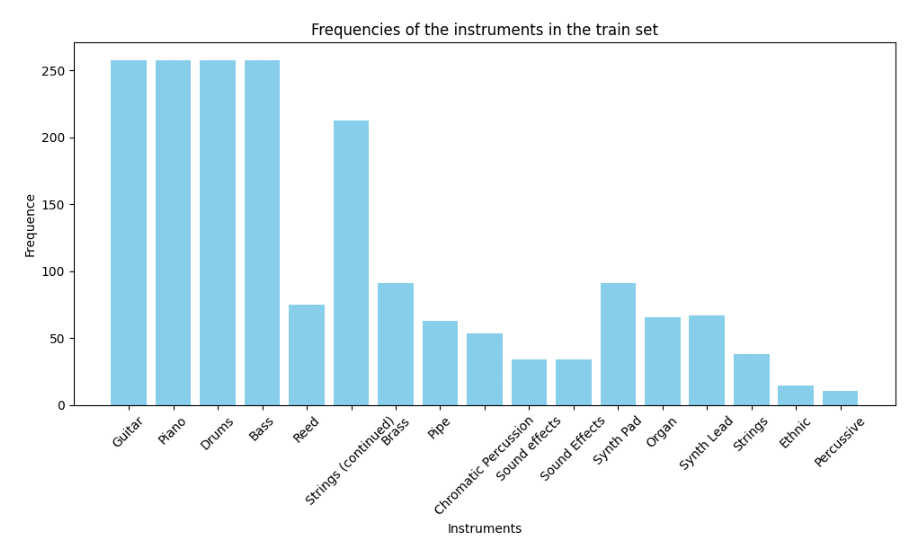

In [11]:
FIG_SIZE = (15, 7)

pathToHistogramTrain = os.path.join(RAW_DATASET_DIR, "histograms/train.png")
pathToHistogramTest = os.path.join(RAW_DATASET_DIR, "histograms/test.png")
pathToHistogramValidation = os.path.join(RAW_DATASET_DIR, "histograms/validation.png")

trainHist = mpimg.imread(pathToHistogramTrain)
plt.figure(figsize=FIG_SIZE)
plt.imshow(trainHist)
plt.axis('off')
plt.show()

## Let's Plot the graphic of some tracks

In [12]:
def plot_waveform(waveform, graph_title: str, from_sec:int = None, to_sec: int = None, sample_rate = 44100):
    if to_sec is not None:
        waveform = waveform[:, :to_sec*sample_rate]

    if from_sec is not None:
        waveform = waveform[:, from_sec*sample_rate:]

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(from_sec if from_sec is not None else 0, num_frames + (from_sec if from_sec is not None else 0)) / sample_rate

    # Crea il plot
    plt.figure(figsize=(15, 5))

    for i in range(num_channels):
        plt.plot(time_axis.numpy(), waveform[i].numpy(), label=f'Channel {i+1}')

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(graph_title)
    plt.legend()
    plt.show()

# Define the Pytorch datasets

In [13]:
# The header of the csv are
#   *_stems.csv -> ['file_path', 'instrument_class', 'midi_program', 'track_name']
#   *_mixes.csv -> ['file_path', 'midi_programs', 'instruments_classes', 'track_name']

#TODO: da sistemare
SAMPLE_RATE = 44100 #Hz

def get_alert_message(path, audio_length):
    return f"The file \"{path}\" is shorter than {audio_length}sec"

class StemsDataset(Dataset):
    def __init__(self, csv_audio_path, audio_length, frac_dataset=None, batch_size=None, transform=None):
        self.audio_csv = pd.read_csv(csv_audio_path, delimiter=';')
        if(frac_dataset != None):
            assert frac_dataset<=1.0 and frac_dataset>0
            sample_size = max(1, int(len(self.audio_csv) * frac_dataset))
            self.audio_csv = self.audio_csv.sample(n=sample_size, random_state=1)

        self.audio_length = audio_length
        self.transform = transform

        # In this way we ensure the last batch have the right size
        if(batch_size is not None):
            self.audio_csv = self.audio_csv.head(len(self.audio_csv) - (len(self.audio_csv) % batch_size))

    def __len__(self):
        return len(self.audio_csv)

    def __getitem__(self, idx):
        audio_path = self.audio_csv.iloc[idx, 0]
        waveform, sample_rate = torchaudio.load(audio_path)
        instrument_class = self.audio_csv.iloc[idx, 1]
        midi_program = self.audio_csv.iloc[idx, 2]

        assert waveform.shape[1] >= SAMPLE_RATE * self.audio_length, get_alert_message(audio_path, self.audio_length)

        if self.transform:
            waveform = self.transform(waveform)

        assert waveform.shape[1]/SAMPLE_RATE >= self.audio_length, f"The transformed audio is too short ({waveform.shape[1]/SAMPLE_RATE}sec)!"

        # take the first audio_length seconds
        waveform = waveform[:,0: SAMPLE_RATE * self.audio_length]

        return waveform

In [14]:
class MixesDataset(Dataset):
    def __init__(self, csv_audio_path, audio_length, frac_dataset=None, batch_size=None, transform=None):
        self.audio_csv = pd.read_csv(csv_audio_path, delimiter=';')
        if(frac_dataset != None):
            assert frac_dataset<=1.0 and frac_dataset>0
            sample_size = max(1, int(len(self.audio_csv) * frac_dataset))
            self.audio_csv = self.audio_csv.sample(n=sample_size, random_state=1)

        self.audio_length = audio_length
        self.transform = transform

        # In this way we ensure the last batch have the right size
        if(batch_size is not None):
            self.audio_csv = self.audio_csv.head(len(self.audio_csv) - (len(self.audio_csv) % batch_size))

    def __len__(self):
        return len(self.audio_csv)

    def __getitem__(self, idx):
        audio_path = self.audio_csv.iloc[idx, 0]
        waveform, sample_rate = torchaudio.load(audio_path)
        midi_programs = ast.literal_eval(self.audio_csv.iloc[idx, 1])
        instruments_class = ast.literal_eval(self.audio_csv.iloc[idx, 2])
        track_name = self.audio_csv.iloc[idx, 3]

        assert waveform.shape[1] >= SAMPLE_RATE * self.audio_length, get_alert_message(audio_path, self.audio_length)

        if self.transform:
            waveform = self.transform(waveform)

        assert waveform.shape[1]/SAMPLE_RATE >= self.audio_length, f"The transformed audio is too short ({waveform.shape[1]/SAMPLE_RATE}sec)!"

        # take the first audio_length seconds
        waveform = waveform[:,0: SAMPLE_RATE * self.audio_length]

        return waveform

# VQ-VAE: The model architecture

## The Vector Quantizer module
We calculate the loss by summing up two terms:
- **codebook loss**, which moves the embedding towards the encoder output;
- **commitment loss**, which makes sure the encoder commits to an embedding;

In [15]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._commitment_cost = commitment_cost

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim) # TODO: Verifica con float64
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)

    def forward(self, inputs):
        # convert inputs from BCW -> BWC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # # Calculate L2-normalized distance between the inputs and the codes
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)                  # a^2
                    + torch.sum(self._embedding.weight.t()**2, dim=0, keepdim=True) # b^2
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))     # -2ab

        # Get the index of the neareast code (from codebook) for each embeddings output by encoder
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # Quantize and unflatten
        quantized = self._embedding(encoding_indices).view(input_shape)

        # Calculating commitment loss and codebook loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs) # commitment loss
        q_latent_loss = F.mse_loss(quantized, inputs.detach()) # codebook loss
        loss = torch.exp(q_latent_loss) + torch.exp(self._commitment_cost * e_latent_loss)

        # Straight-through estimator trick for gradient backpropagation
        quantized = inputs + (quantized - inputs).detach()

        # Create a one-hot matrix where the ones at (i, j) position
        #   indicates that the j-th code, from codebook, it was selected
        #   for the i-th embedding vector output by the encoder.
        one_hot_enc = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        one_hot_enc.scatter_(1, encoding_indices, 1)

        # Calculates the average probability of the utilization of each code from codebook
        avg_probs = torch.mean(one_hot_enc, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BWC -> BCHW
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, quantized


In [16]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._commitment_cost = commitment_cost
        self._decay = decay
        self._epsilon = epsilon

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim) # TODO: Verifica con float64
        self._embedding.weight.data.normal_()

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

    def forward(self, inputs):
        # convert inputs from BCW -> BWC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # # Calculate L2-normalized distance between the inputs and the codes
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)                  # a^2
                    + torch.sum(self._embedding.weight.t()**2, dim=0, keepdim=True) # b^2
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))     # -2ab

        # Get the index of the neareast code (from codebook) for each embeddings output by encoder
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # Quantize and unflatten
        quantized = self._embedding(encoding_indices).view(input_shape)

        # Create a one-hot matrix where the ones at (i, j) position
        #   indicates that the j-th code, from codebook, it was selected
        #   for the i-th embedding vector output by the encoder.
        one_hot_enc = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        one_hot_enc.scatter_(1, encoding_indices, 1)

        # Use EMA to update the embedding vectors (codebook)
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(one_hot_enc, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(one_hot_enc.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Calculating commitment loss and codebook loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs) # commitment loss
        loss = torch.exp(self._commitment_cost * e_latent_loss)

        # Straight-through estimator trick for gradient backpropagation
        quantized = inputs + (quantized - inputs).detach()

        # Calculates the average probability of the utilization of each code from codebook
        avg_probs = torch.mean(one_hot_enc, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BWC -> BCHW
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, quantized

## The ResNet module

In [17]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()

        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv1d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv1d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()

        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

## Some utility functions

In [18]:
from math import log2

def get_levels(end, num_layers, reverse=False):
    '''This function returns a list of 2-ple (input_channels, output_channels) representing the
    input and output dimensions of each encoder/decoder block.
    Each two subsequent layer it will be a halving/doubling of the dimensionality of the output channels.

    For example, for end=128 and num_layers=4,
    it will return:
            1 -> 16
            16 -> 32
            32 -> 64
            64 -> 128
    '''
    input_hiddens = []
    output_hiddens = []

    if (log2(end) - (int(log2(end))) > 0):
        raise RuntimeError(f"{end} isn't power of 2")
    elif (log2(end) < num_layers):
        raise RuntimeError(f"num_layers ({num_layers}) is greater than the number of powers of 2 ({int(log2(end))}) for {end}")

    while(end>=2 and num_layers>0):
        last = not (end//2>=2 and num_layers-1>0)
        input_hiddens.append(end//2 if not last else 1)
        output_hiddens.append(end)

        # Update the loop parameters
        end = end//2
        num_layers-=1

    input_hiddens, output_hiddens = input_hiddens[::-1 if not reverse else None], output_hiddens[::-1 if not reverse else None]

    if reverse:
        return zip(output_hiddens, input_hiddens)
    else:
        return zip(input_hiddens, output_hiddens)

## The Encoder architecture

In [19]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation_function):
        super(EncoderBlock, self).__init__()

        self._activation_function = activation_function
        self._conv = nn.Conv1d( in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=4,
                                stride=2,
                                padding=1)

    def forward(self, x):
        x = self._conv(x)
        x = self._activation_function(x)
        return x


class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_halving_layers, num_residual_layers, num_residual_hiddens):
        '''The encoder takes a in_channels-dimensional embedding sequence of length N as input
        and maps it in a sequence N/"2^num_halving_layers" smaller of embeddings of dimension "num_hiddens".
        '''

        super(Encoder, self).__init__()
        self._block_activation_function = nn.ReLU()

        self._layers = [
            EncoderBlock(in_channels=_in_channels,
                         out_channels=_out_channels,
                         activation_function=nn.Identity() if (_out_channels == num_hiddens) else self._block_activation_function
            )
            for _in_channels, _out_channels in get_levels(num_hiddens, num_halving_layers)
        ] + [
            nn.Conv1d(  in_channels=num_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=3,
                        stride=1,
                        padding=1),

            ResidualStack(  in_channels=num_hiddens,
                            num_hiddens=num_hiddens,
                            num_residual_layers=num_residual_layers,
                            num_residual_hiddens=num_residual_hiddens),
        ]

        self._encoder = nn.Sequential(*self._layers)

    def forward(self, inputs):
        return self._encoder(inputs)

## The Decoder architecture

In [20]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation_function):
        super(DecoderBlock, self).__init__()

        self._conv = nn.ConvTranspose1d(in_channels=in_channels,
                                        out_channels=out_channels,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self._activation_function = activation_function

    def forward(self, x):
        x = self._conv(x)
        x = self._activation_function(x)
        return x

class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_doubling_layer, num_residual_layers, num_residual_hiddens):
        '''The decoder takes a in_channels-dimensional embedding sequence of length N as input
        and maps it in a sequence N*"2^num_doubling_layer" longer of embeddings of dimension "num_hiddens".
        '''
        super(Decoder, self).__init__()

        self._block_activation_function = nn.ReLU()
        self._output_activation_func = nn.Tanh()  # Output values in range [-1, 1]

        self._layers = [
            nn.Conv1d(  in_channels=num_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=3,
                        stride=1,
                        padding=1),

            ResidualStack(in_channels=num_hiddens,
                        num_hiddens=num_hiddens,
                        num_residual_layers=num_residual_layers,
                        num_residual_hiddens=num_residual_hiddens)
        ] + [
            DecoderBlock(in_channels=_in_channels,
                        out_channels=_out_channels,
                        activation_function=nn.Identity() if (_out_channels == 1) else self._block_activation_function)
            for _in_channels, _out_channels in get_levels(num_hiddens, num_doubling_layer, reverse=True)
        ]

        self._decoder = nn.Sequential(*self._layers)

    def forward(self, x):
        x = self._decoder(x)
        return self._output_activation_func(x)

## The VQ-VAE model

In [21]:
class VQVAE(nn.Module):
    def __init__(self, num_hiddens, num_halving_layers, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay):

        super(VQVAE, self).__init__()

        self._encoder = Encoder(1,
                                num_hiddens,
                                num_halving_layers,
                                num_residual_layers,
                                num_residual_hiddens)

        # It maps the "num_hiddens-dimensional" embedding sequence in a "embedding_dim-dimensional" sequence
        #   preparing it for quantization
        self._pre_vq_conv = nn.Conv1d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)

        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                               commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                            commitment_cost)

        # It maps the "embedding_dim-dimensional" embedding sequence in a "num_hiddens-dimensional" embeddin sequence
        #   preparing it for the decoding operation (added by me)
        self._post_vq_conv = nn.Conv1d(in_channels=embedding_dim,
                                       out_channels=num_hiddens,
                                       kernel_size=1,
                                       stride=1)

        self._decoder = Decoder(num_hiddens,
                                num_hiddens,
                                num_halving_layers,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        decoder_input = self._post_vq_conv(quantized)
        x_recon = self._decoder(decoder_input)

        return loss, x_recon, perplexity

# Training of the VQ-VAE

## Select the device (cpu or gpu)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"You are using {device}!")

You are using cuda!


## Define the hyper parameters

In [26]:
if USE_PRE_SAVED_MODEL:
    with open(PATH_TO_HYPERPARAMETERS, 'r') as hyper_params_file:
        HYPER_PARAMS = json.load(hyper_params_file)
        HYPER_PARAMS["epochs"] = EPOCHS_RE_TRAIN

elif ONLY_EVALUATION:
    with open(PATH_TO_HYPERPARAMETERS_EVALUATION, 'r') as hyper_params_file:
        HYPER_PARAMS = json.load(hyper_params_file)
else:
    HYPER_PARAMS = {
        "batch_size": 10,
        "dataset_frac_size": 0.40,
        "epochs": 20000,

        # Inputs audio track length in seconds
        "audio_length": 16,

        # Control the silence in the track
        "remove_silence": True,

        # Dimensionality of each encoded vector before quantization
        "num_hiddens": 128,
        "num_halving_layers": 6,

        # The ResNet parameters
        "num_residual_hiddens": 64,
        "num_residual_layers": 3,

        # The dimensionality of the space where the codebook lies
        "embedding_dim": 64,

        # Number of the codes in the codebook
        "num_embeddings": 512,

        # To make sure the encoder commits to an embedding
        "commitment_cost": 1.0,
        "decay": 0.99,
        "learning_rate": 0.0002,
    }

Save the hyper params configuration in the training dir

In [27]:
if not ONLY_EVALUATION:
    with open(os.path.join(CURR_CHECKPOINT_DIR, "hyper_params.json"), 'w') as hyp_params_file:
        json.dump(HYPER_PARAMS, hyp_params_file, indent=4)

## Create the Datasets

### Define the transformation function

In [24]:
def trim_silence(waveform: torch.Tensor):
    return waveform[waveform != 0].unsqueeze(0)

### Build the Pytorch dataset object

In [28]:
if USE_STEMS:
    train_set = StemsDataset(
                    os.path.join(DATASET_HOME_DIR, "train_stems.csv"),
                    HYPER_PARAMS['audio_length'],
                    batch_size=HYPER_PARAMS['batch_size'],
                    transform=trim_silence if HYPER_PARAMS['remove_silence'] else None
    )
    test_set = StemsDataset(
                    os.path.join(DATASET_HOME_DIR, "test_stems.csv"),
                    HYPER_PARAMS['audio_length'],
    )
    validation_set = StemsDataset(
                    os.path.join(DATASET_HOME_DIR, "validation_stems.csv"),
                    HYPER_PARAMS['audio_length'],
                    batch_size=HYPER_PARAMS['batch_size']
    )
else:
    train_set = MixesDataset(
                    os.path.join(DATASET_HOME_DIR, "train_mixes.csv"),
                    HYPER_PARAMS['audio_length'],
                    frac_dataset=HYPER_PARAMS['dataset_frac_size']
    )
    test_set = MixesDataset(
                    os.path.join(DATASET_HOME_DIR, "test_mixes.csv"),
                    HYPER_PARAMS['audio_length'],
                    frac_dataset=HYPER_PARAMS['dataset_frac_size']
    )
    validation_set = MixesDataset(
                    os.path.join(DATASET_HOME_DIR, "validation_mixes.csv"),
                    HYPER_PARAMS['audio_length'],
                    frac_dataset=HYPER_PARAMS['dataset_frac_size']
    )

print(f"Train stems len: {len(train_set)}")
print(f"Test stems len: {len(test_set)}")
print(f"Validation stems len: {len(validation_set)}")

Train stems len: 102
Test stems len: 12
Validation stems len: 21


## Create the Dataloaders

In [29]:
if not ONLY_EVALUATION:
    train_vqvae_dataloader = DataLoader(train_set, batch_size=HYPER_PARAMS['batch_size'], shuffle=True)
    validation_vqvae_dataloader = DataLoader(validation_set, batch_size=HYPER_PARAMS['batch_size'], shuffle=True)

## Configure the model to train
If we set the 'USE_PRE_SAVED_MODEL' to *True* then the selected pre-saved model will be train, else a new one will be created.

In [30]:
if not ONLY_EVALUATION:
    # define the model
    model = VQVAE(
        HYPER_PARAMS["num_hiddens"],
        HYPER_PARAMS["num_halving_layers"],
        HYPER_PARAMS["num_residual_layers"],
        HYPER_PARAMS["num_residual_hiddens"],
        HYPER_PARAMS["num_embeddings"],
        HYPER_PARAMS["embedding_dim"],
        HYPER_PARAMS["commitment_cost"],
        HYPER_PARAMS["decay"]
    ).to(device)

    if USE_PRE_SAVED_MODEL:
        model.load_state_dict(
            torch.load(PATH_TO_PRE_SAVED_MODEL, map_location=torch.device('cuda'))
        )

    optimizer = optim.Adam(model.parameters(), lr=HYPER_PARAMS['learning_rate'], amsgrad=False)

## Define a per-epoch training function

In [31]:
def plot_loss_and_perplexity(train_res_recon_error, train_res_perplexity):
    WINDOW_LENGTH = 201

    f = plt.figure(figsize=(16,8))
    ax = f.add_subplot(1,2,1)
    ax.plot(savgol_filter(train_res_recon_error, WINDOW_LENGTH, 7))
    ax.set_yscale('log')
    ax.set_title('Smoothed NMSE.')
    ax.set_xlabel('epochs')

    ax = f.add_subplot(1,2,2)
    ax.plot(savgol_filter(train_res_perplexity, WINDOW_LENGTH, 7))
    ax.set_title('Smoothed Average codebook usage (perplexity).')
    ax.set_xlabel('epochs')

    f.savefig(os.path.join(EVAL_CHECKPOINT_DIR if ONLY_EVALUATION else CURR_CHECKPOINT_DIR, "loss_and_perplexity.png"))

In [32]:
def train_one_epoch(train_dataloader: DataLoader, epoch_index, tb_writer):

    train_res_recon_error = []
    train_res_perplexity = []

    for _, inputs in enumerate(train_dataloader):

        inputs = inputs.to(device)

        data_variance = torch.var(inputs, correction=0)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        vq_loss, data_recon, perplexity = model(inputs)

        # Compute the losses and its gradients
        recon_error = F.mse_loss(data_recon, inputs) / data_variance
        #vq_loss = vq_loss / data_variance
        loss = recon_error + vq_loss
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

    return np.mean(train_res_recon_error), np.mean(train_res_perplexity)

## Define the main training function

In [33]:
KEEP_LAST_N_MODELS = 5
THRESHOLD_ERROR_TO_SAVE_MODEL = 0.2

def training_loop():

    # Initializing in a separate cell so we can easily add more epochs to the same run
    timestamp = (datetime.now() + timedelta(hours=2)).strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
    epoch_number = 0

    best_recon_error = 1_000_000
    best_perplexity = 1_000_000

    # To keep track of the saved models
    saved_models = []

    # To keep track of the loss and perplexity along epochs and finally plot the graphs
    train_recon_error_per_epoch = []
    train_perplexity_per_epoch = []

    with tqdm(total=HYPER_PARAMS["epochs"]) as pbar:
        for epoch in range(HYPER_PARAMS["epochs"]):
            log('EPOCH {}'.format(epoch_number + 1))

            # Make sure gradient tracking is on, and do a pass over the data
            model.train()
            avg_train_recon_error, avg_train_perplexity = train_one_epoch(train_vqvae_dataloader,epoch_number, writer)

            # Store statistics
            train_recon_error_per_epoch.append(avg_train_recon_error)
            train_perplexity_per_epoch.append(avg_train_perplexity)

            # Set the model to evaluation mode, disabling dropout and using population
            # statistics for batch normalization.
            model.eval()

            valid_res_recon_error = []
            valid_res_perplexity = []

            # Disable gradient computation and reduce memory consumption.
            with torch.no_grad():
                for i, valid_inputs in enumerate(validation_vqvae_dataloader):
                    valid_inputs = valid_inputs.to(device)
                    data_variance = torch.var(valid_inputs, correction=0)
                    valid_vq_loss, valid_data_recon, valid_perplexity = model(valid_inputs)
                    recon_error = F.mse_loss(valid_data_recon, valid_inputs) / data_variance
                    valid_res_recon_error.append(recon_error.item())
                    valid_res_perplexity.append(valid_perplexity.item())

            avg_valid_recon_error = np.mean(valid_res_recon_error)
            avg_valid_perplexity = np.mean(valid_res_perplexity)

            # Log error and perplexity
            log(f"Train reconstruction error: {avg_train_recon_error} - Validation reconstruction error: {avg_valid_recon_error}")
            log(f"Train perplexity: {avg_train_perplexity} - Validation perplexity: {avg_valid_perplexity}")

            pbar.set_postfix({
                'Train reconstruction err': f'{avg_train_recon_error:.5f}',
                'Train perplexity': f'{avg_train_perplexity:.5f}'
            })

            # Log the running loss averaged per batch
            # for both training and validation
            writer.add_scalars('Training vs. Validation reconstruction Loss',
                            { 'Training' : avg_train_recon_error, 'Validation' : avg_valid_recon_error },
                            epoch_number + 1)
            writer.flush()

            # Track best performance, and save the model's state
            if (avg_valid_recon_error < THRESHOLD_ERROR_TO_SAVE_MODEL) and (
                avg_valid_recon_error < best_recon_error or avg_valid_perplexity < best_perplexity):

                best_recon_error = avg_valid_recon_error
                best_perplexity = avg_valid_perplexity

                model_name = 'VQVAE_{}_EPOCH'.format(epoch_number + 1)
                model_path = os.path.join(CURR_CHECKPOINT_DIR, model_name)
                torch.save(model.state_dict(), model_path)

                # Keep track of saved models
                saved_models.append(model_path)

                # delete too old saved models
                if len(saved_models) > KEEP_LAST_N_MODELS:
                    os.remove(saved_models[0])
                    saved_models = saved_models[1:]

            epoch_number += 1
            pbar.update(1)

    plot_loss_and_perplexity(train_recon_error_per_epoch, train_perplexity_per_epoch)

## Train!

In [ ]:
if not ONLY_EVALUATION:
    training_loop()

# Quantitative Evaluation

In [ ]:
# Create the dataloader for the test set
test_dataloader = DataLoader(validation_set, batch_size=1, shuffle=False)

In [ ]:
# load modeln
model = VQVAE(
    HYPER_PARAMS["num_hiddens"],
    HYPER_PARAMS["num_halving_layers"],
    HYPER_PARAMS["num_residual_layers"],
    HYPER_PARAMS["num_residual_hiddens"],
    HYPER_PARAMS["num_embeddings"],
    HYPER_PARAMS["embedding_dim"],
    HYPER_PARAMS["commitment_cost"],
    HYPER_PARAMS["decay"]
).to(device)

model.load_state_dict(
    torch.load(PATH_TO_MODEL_TO_EVALUATE, map_location=torch.device('cuda'))
)

_ = model.eval()

In [ ]:
data_iterator = iter(test_dataloader)
batch_number = 1

In [ ]:
batch_test_inputs = next(data_iterator).to(device)
print(f"Batch number: {batch_number}")
batch_number += 1
test_vq_loss, test_data_recon, test_perplexity = model(batch_test_inputs)
batch_data_variance = torch.var(batch_test_inputs, correction=0)
print(f"Test perplexity: {test_perplexity}")
print(f"Test data_variance: {batch_data_variance}")
print(f"Test vq_loss: {test_vq_loss}")
print(f"Test recon_error: {F.mse_loss(test_data_recon, batch_test_inputs) / batch_data_variance}")

In [ ]:
# @title Play with model results {"run":"auto","vertical-output":true}
num = 0 # @param {"type":"slider","min":0,"max":4,"step":1}
import IPython.display as ipd
import librosa

audio_numpy_v = batch_test_inputs.detach().cpu()[num][0].numpy()
audio_numpy_r = test_data_recon.detach().cpu()[num][0].numpy()

# Usa IPython.display per riprodurre l'audio
ipd.display(ipd.Audio(audio_numpy_v, rate=44100))
ipd.display(ipd.Audio(audio_numpy_r, rate=44100))
plot_waveform(batch_test_inputs.cpu()[num], graph_title="Original waveform")
plot_waveform(test_data_recon.detach().cpu()[num], graph_title="Reconstructed waveform")